In [1]:
import pandas as pd
import numpy as np
import warnings
import re
from collections import Counter
#from gensim.summarization import keywords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
df_data = pd.read_csv("AssignmentData.csv")

In [3]:
df_data['Date']= pd.to_datetime(df_data['Date'], format='%d/%m/%y')
df_data.dtypes

Id                     object
Date           datetime64[ns]
Site_Type              object
Site                   object
URL                    object
Author_name            object
Title                  object
Content                object
Sentiment              object
Country                object
dtype: object

In [4]:
df_data.head()

Id       Date       Site_Type      Site  \
0  210540-102609514645 2018-06-30         Twitter   Twitter   
1  210540-102611998758 2018-06-30  Social network  Facebook   
2  210540-102611998754 2018-06-30  Social network  Facebook   
3  210540-102611998745 2018-06-30  Social network  Facebook   
4  210540-102611998682 2018-06-30  Social network  Facebook   

                                                 URL     Author_name  \
0  http://twitter.com/SethSkeller/status/10133113...     Seth Keller   
1                                                NaN  Anonymous user   
2                                                NaN  Anonymous user   
3                                                NaN  Anonymous user   
4                                                NaN  Anonymous user   

                                          Title  \
0  RT @mattrob_3: . @dexcom sponsor your boy ☀️   
1                                        Dexcom   
2                                        Dexcom   
3                                        Dexcom   
4                                        Dexcom   

                                             Content Sentiment        Country  
0       RT @mattrob_3: . @dexcom sponsor your boy ☀️   neutral         France  
1  Another thing. kaiser DM never calls back. You...   neutral  United States  
2  Don’t wait for Kaiser DM. Call your Endo and a...   neutral  United States  
3     My son has been wearing the G6 for 3 days now!   neutral  United States  
4         It’s a lot better. But the 5 is great too.  positive  United States

### 1. Perform trend analysis on data and identify peak or low on particular date (if any) and the possible reason for it

In [42]:
# creating a new dataframe with column for month weekday and date as index
df_trend = df_data.copy()
df_trend['weekday'] = df_trend['Date'].dt.dayofweek
df_trend['Month'] = df_trend['Date'].dt.month
df_trend = df_trend.set_index(["Date"])
df_trend.head()

Id       Site_Type      Site  \
Date                                                        
2018-06-30  210540-102609514645         Twitter   Twitter   
2018-06-30  210540-102611998758  Social network  Facebook   
2018-06-30  210540-102611998754  Social network  Facebook   
2018-06-30  210540-102611998745  Social network  Facebook   
2018-06-30  210540-102611998682  Social network  Facebook   

                                                          URL     Author_name  \
Date                                                                            
2018-06-30  http://twitter.com/SethSkeller/status/10133113...     Seth Keller   
2018-06-30                                                NaN  Anonymous user   
2018-06-30                                                NaN  Anonymous user   
2018-06-30                                                NaN  Anonymous user   
2018-06-30                                                NaN  Anonymous user   

                                                   Title  \
Date                                                       
2018-06-30  RT @mattrob_3: . @dexcom sponsor your boy ☀️   
2018-06-30                                        Dexcom   
2018-06-30                                        Dexcom   
2018-06-30                                        Dexcom   
2018-06-30                                        Dexcom   

                                                      Content Sentiment  \
Date                                                                      
2018-06-30       RT @mattrob_3: . @dexcom sponsor your boy ☀️   neutral   
2018-06-30  Another thing. kaiser DM never calls back. You...   neutral   
2018-06-30  Don’t wait for Kaiser DM. Call your Endo and a...   neutral   
2018-06-30     My son has been wearing the G6 for 3 days now!   neutral   
2018-06-30         It’s a lot better. But the 5 is great too.  positive   

                  Country  weekday  Month  
Date                                       
2018-06-30         France        5      6  
2018-06-30  United States        5      6  
2018-06-30  United States        5      6  
2018-06-30  United States        5      6  
2018-06-30  United States        5      6

Lets create a graph for the user enagement for each date

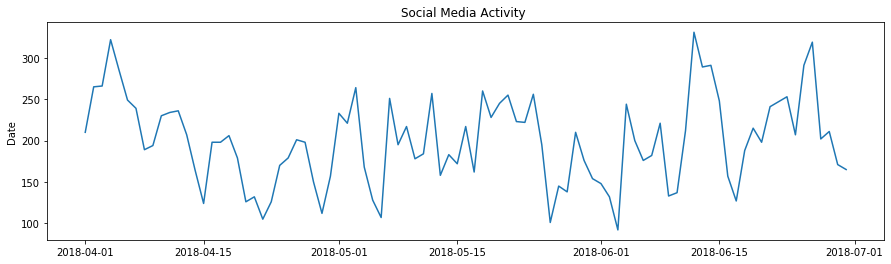

In [43]:
#get post count for each date
y_date = df_trend.groupby('Date').size() 

plt.figure(figsize=(15, 4))
plt.plot(y_date)
plt.title('Social Media Activity ')
plt.ylabel('Date');
plt.show()

Dates with highest engaement

In [8]:
y_date.nlargest(n=5, keep='first')

Date
2018-06-12    331
2018-04-04    322
2018-06-26    319
2018-06-14    291
2018-06-25    291
dtype: int64

Lets create a graph for the user enagement based on weekday

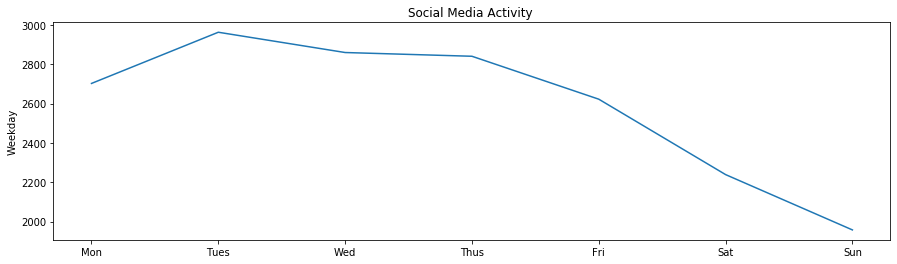

In [44]:
#get post count for each date
y_day_of_week = df_trend.groupby('weekday').size() 

plt.figure(figsize=(15, 4))
plt.plot( ['Mon', 'Tues', 'Wed', 'Thus', 'Fri', 'Sat', 'Sun'], y_day_of_week)
plt.title('Social Media Activity ')
plt.ylabel('Weekday');
plt.show()

#####  As seen in above there are more number of enagement between 4th June 2018 to 12 jun 2018. The 4 june 2018 is the launch date of the Dexcom G6 this is the reason for more number of tweets. The hike may be because the device was shipped after 4th to customer and they have tried the devices and were talikh about it. 

## 2. For Twitter data; 
    (a) Identify the most common hashtags across the data
    (b) Identify the most referenced link or article
    (c) Identify engaging tweets with most retweets

In [46]:
#collect haghtag and URL form the content column considering the words length greater than 3
df_twitter = df_data[df_data.Site_Type == 'Twitter']
content_list = df_twitter.Content.tolist()
hastags = []
urls = []
customer_service = []
for text in content_list: 
    for w in text.split():
        if len(w) > 3 and w[0] =='#':
            hastags.append(w)
    tmp = re.findall("(?P<url>https?://[^\s]+)", text)
    if len(tmp) > 0:
        urls= urls + tmp

### (a) Identify the most common hashtags across the data


In [47]:
hastags_count = Counter(hastags)
hastags_count.most_common(15)

[('#Dexcom', 252),
 ('#T1D', 235),
 ('#dexcom', 231),
 ('#gbdoc', 171),
 ('#t1d', 134),
 ('#CGM', 119),
 ('#type1diabetes', 96),
 ('#DiabetesAwarenessWeek,', 89),
 ('#WeAreNotWaiting', 67),
 ('#DOC', 64),
 ('#doc', 61),
 ('#dsma', 53),
 ('#markets', 46),
 ('#OpenAPS', 46),
 ('#GBDOC', 45)]

In [16]:
labels, values = zip(*hastags_count.most_common(15))

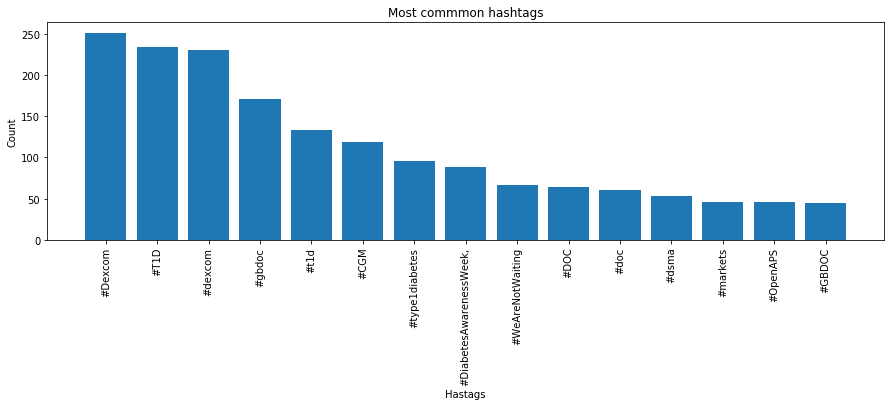

In [17]:
plt.figure(figsize=(15, 4))
plt.bar( labels, values)
plt.title('Most commmon hashtags')
plt.ylabel('Count');
plt.xlabel('Hastags');
plt.xticks(rotation='90')
plt.show()

#### (b) Identify the most referenced link or article

In [18]:
urls_count = Counter(urls)
df_url = pd.DataFrame(urls_count.most_common(15), columns=['URL','Count'])
df_url

URL  Count
0   https://www.cnbc.com/2018/05/12/dexcom-g6-revi...    212
1   https://www.cnbc.com/2018/05/12/dexcom-g6-revi...     44
2   http://circles-of-blue.winchcombe.org/index.ph...     38
3   https://www.justgiving.com/crowdfunding/diathl...     28
4   https://www.facebook.com/DexcomUK/posts/185199...     24
5   https://diatribe.org/dexcom-g6-cgm-no-fingerst...     23
6   https://www.eventbrite.co.uk/e/sport1day-shari...     22
7   https://timesofsandiego.com/life/2018/06/25/ko...     19
8   https://www.cnbc.com/2018/05/12/dexcom-g6-revi...     19
9   https://beyondtype1.org/comparing-the-dexcom-g...     18
10    https://beyondtype1.org/fda-approves-dexcom-g6/     16
11  https://twitter.com/mtl613/status/100199428942...     15
12                  https://events.bizzabo.com/dexcom     14
13  https://www.diabetesdaily.com/blog/dexcom-g6-r...     14
14       https://events.bizzabo.com/dexcom?share=true     13

#### (c) Identify engaging tweets with most retweets

In [19]:
df_twitter_rt = df_twitter[df_twitter.Content.str.startswith('RT')]
df_twitter_rt_count = df_twitter_rt.groupby('Content').size().to_frame().reset_index()
df_twitter_rt_count.columns = ['Tweet', 'Retweet Count']
df_twitter_rt_count.sort_values(by='Retweet Count', ascending=False)

Tweet  Retweet Count
53   RT @CNBC: Dexcom's newest diabetes device can ...            122
467  RT @jginorton: Since it’s #DiabetesAwarenessWe...             77
54   RT @CNBC: This diabetes device can read your b...             47
136  RT @Fallabel: all I can say is we have an acce...             23
402  RT @diaTribeNews: Tech triple whammy! FDA appr...             19
..                                                 ...            ...
267  RT @PeterDonn973: @GingerVieira @dexcom In the...              1
266  RT @PeterAttiaMD: Hell yes. I'm currently wear...              1
262  RT @Paddy_English: @RoddyRiddle @JamesEPMoran ...              1
258  RT @Oxeyedaiseygirl: Approved for the #Dexcom ...              1
629  RT kellyclose: dexcom’s annikaalford talking a...              1

[630 rows x 2 columns]

## 3. List of countries having the highest  positive and negative Sentiment for each date 

In [48]:
#seletec columsn with positve or negative sentiment and having a value for country
data_setiment = df_data[(df_data.Country !='Not available')]
data_setiment = data_setiment[(data_setiment.Sentiment !='neutral')]
data_setiment = data_setiment.set_index(["Date"])

Get Country with top positive sentiment count for each date.

In [50]:
data_setiment_pos = data_setiment[(data_setiment.Sentiment =='positive')]
df_sent_pos  = data_setiment_pos.groupby(['Date', 'Sentiment', 'Country']).size().reset_index()
df_sent_pos.columns=['Date','Sentiment', 'Country', 'Count']
df_sent_pos.head()

Date Sentiment         Country  Count
0 2018-04-01  positive       Australia      3
1 2018-04-01  positive         Austria      1
2 2018-04-01  positive          Canada      1
3 2018-04-01  positive           China      1
4 2018-04-01  positive  United Kingdom      7

In [51]:
df_sent_pos.sort_values(by=['Date','Sentiment', 'Country', 'Count'], ascending=False, inplace=True )
df_sent_pos.drop_duplicates(subset=['Date','Sentiment'],inplace=True)
df_sent_pos.set_index('Date',inplace=True )
df_sent_pos.head()

Sentiment        Country  Count
Date                                      
2018-06-30  positive  United States     28
2018-06-29  positive  United States     14
2018-06-28  positive  United States     28
2018-06-27  positive  United States     25
2018-06-26  positive  United States     51

Get Country with to Negative sentiment count for each date.

In [52]:
data_setiment_neg = data_setiment[(data_setiment.Sentiment =='negative')]
df_sent_neg  = data_setiment_neg.groupby(['Date', 'Sentiment', 'Country']).size().reset_index()
df_sent_neg.columns=['Date','Sentiment', 'Country', 'Count']
df_sent_neg.head()

Date Sentiment         Country  Count
0 2018-04-01  negative  United Kingdom      1
1 2018-04-01  negative   United States      4
2 2018-04-02  negative           India      1
3 2018-04-02  negative  United Kingdom      1
4 2018-04-02  negative   United States      7

In [53]:
df_sent_neg.sort_values(by=['Date','Sentiment', 'Country', 'Count'], ascending=False, inplace=True )
df_sent_neg.drop_duplicates(subset=['Date','Sentiment'],inplace=True)
df_sent_neg.set_index('Date',inplace=True)
df_sent_neg.head()

Sentiment        Country  Count
Date                                      
2018-06-30  negative  United States     15
2018-06-29  negative  United States     12
2018-06-28  negative  United States     11
2018-06-27  negative  United States      7
2018-06-26  negative  United States     17

In [54]:
df_sent_pos.sort_values(by='Date',inplace=True)
df_sent_neg.sort_values(by='Date',inplace=True)

Collect the top positive and negative country for each date in one DF 

In [55]:
df_final = df_sent_pos[['Country']].copy()
df_final['country_negative'] = df_sent_neg[['Country']].copy()
df_final.columns=['country_positive','country_negative']
df_final

country_positive country_negative
Date                                        
2018-04-01    United States    United States
2018-04-02    United States    United States
2018-04-03    United States    United States
2018-04-04    United States    United States
2018-04-05    United States    United States
...                     ...              ...
2018-06-26    United States    United States
2018-06-27    United States    United States
2018-06-28    United States    United States
2018-06-29    United States    United States
2018-06-30    United States    United States

[91 rows x 2 columns]

### 4. Extract customer service related phrases from the messages (post or reply) and categorized them into - Satisfied and Unsatisfied.  

In [56]:
#convert all the text to lower case
df_data_cs = df_data[['Date', 'Title', 'Content', 'Sentiment']].copy()
df_data_cs.Content = df_data_cs.Content.str.lower()

In [57]:
#filter and keep only record related to customer service
df_data_cs =  df_data_cs[df_data_cs.Content.str.contains('customer service')]

In [58]:
df_data_cs.head()

Date   Title                                            Content  \
137 2018-06-30  Dexcom  ali, my son is on the list for the g6 with edg...   
229 2018-06-29  Dexcom  cam someone please call me from customer servi...   
251 2018-06-29  Dexcom  i am a camp nurse, have not had campers with d...   
270 2018-06-29  Dexcom  hi tom. to discuss coverage through veteran's ...   
436 2018-06-28  Dexcom  hi barry. if you're interested, please feel fr...   

    Sentiment  
137   neutral  
229  negative  
251   neutral  
270   neutral  
436   neutral

In [59]:
df_data_cs.Sentiment = df_data_cs.Sentiment.replace(['negative', 'positive'], ['Unsatisfied','Satisfied']) 

In [60]:
df_data_cs.head()

Date   Title                                            Content  \
137 2018-06-30  Dexcom  ali, my son is on the list for the g6 with edg...   
229 2018-06-29  Dexcom  cam someone please call me from customer servi...   
251 2018-06-29  Dexcom  i am a camp nurse, have not had campers with d...   
270 2018-06-29  Dexcom  hi tom. to discuss coverage through veteran's ...   
436 2018-06-28  Dexcom  hi barry. if you're interested, please feel fr...   

       Sentiment  
137      neutral  
229  Unsatisfied  
251      neutral  
270      neutral  
436      neutral

### 5. Extract top 500 keywords from the dataset and cluster them into relevant groups. 

In [61]:
df_data.head()

Id       Date       Site_Type      Site  \
0  210540-102609514645 2018-06-30         Twitter   Twitter   
1  210540-102611998758 2018-06-30  Social network  Facebook   
2  210540-102611998754 2018-06-30  Social network  Facebook   
3  210540-102611998745 2018-06-30  Social network  Facebook   
4  210540-102611998682 2018-06-30  Social network  Facebook   

                                                 URL     Author_name  \
0  http://twitter.com/SethSkeller/status/10133113...     Seth Keller   
1                                                NaN  Anonymous user   
2                                                NaN  Anonymous user   
3                                                NaN  Anonymous user   
4                                                NaN  Anonymous user   

                                          Title  \
0  RT @mattrob_3: . @dexcom sponsor your boy ☀️   
1                                        Dexcom   
2                                        Dexcom   
3                                        Dexcom   
4                                        Dexcom   

                                             Content Sentiment        Country  
0       RT @mattrob_3: . @dexcom sponsor your boy ☀️   neutral         France  
1  Another thing. kaiser DM never calls back. You...   neutral  United States  
2  Don’t wait for Kaiser DM. Call your Endo and a...   neutral  United States  
3     My son has been wearing the G6 for 3 days now!   neutral  United States  
4         It’s a lot better. But the 5 is great too.  positive  United States

Process the text to get the top 500 key words we followed below steps
1. Combine the Title and Content into one single column.
2. Convert text to lower case
3. filter text to only keep text and removing digit, punctuation and special character.

In [36]:
df_data_keywords = df_data.copy()
df_data_keywords['text'] = df_data_keywords['Title'] +' '+ df_data_keywords['Content']
text = str(list(df_data_keywords['text'] ))
text = text.lower()
text = re.sub('[^a-z]', ' ' ,text)
text

'  rt  mattrob       dexcom sponsor your boy    rt  mattrob       dexcom sponsor your boy       dexcom another thing  kaiser dm never calls back  you just need to wait on line     minutes always  to speak with someone     dexcom don t wait for kaiser dm  call your endo and ask them to put in a new prescription for the g   then dm will forward it to dexcom    dexcom my son has been wearing the g  for   days now     dexcom it s a lot better  but the   is great too     inserting a dexcom sensor at comic con   another day in the life of a type   diabetic  going to cons is my favourite hobby  it would take hours to list everyone ive ever cosplayed  league of legends champions and anime characters pretty much covers it though    dexcom our son got his last week and it s amazing       i get it  awareness  but i m still upset i can t get another dexcom and soooo many should have one  my dear friend had constant lows and seizures and her dex saved her life more than once  worries me how many mo

Further processing the data
4. Remove th stop words for the text.
5. Tokenize the text into words.
6. Applying lemmitization for each word.

In [37]:
stop_words = stopwords.words('english')
new_stopwords = ['rt', 'g', 'dm']
stop_words.extend(new_stopwords)
tokenizer = word_tokenize(text)
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w) for w in tokenizer if w not in stop_words ]
words

['mattrob',
 'dexcom',
 'sponsor',
 'boy',
 'mattrob',
 'dexcom',
 'sponsor',
 'boy',
 'dexcom',
 'another',
 'thing',
 'kaiser',
 'never',
 'call',
 'back',
 'need',
 'wait',
 'line',
 'minute',
 'always',
 'speak',
 'someone',
 'dexcom',
 'wait',
 'kaiser',
 'call',
 'endo',
 'ask',
 'put',
 'new',
 'prescription',
 'forward',
 'dexcom',
 'dexcom',
 'son',
 'wearing',
 'day',
 'dexcom',
 'lot',
 'better',
 'great',
 'inserting',
 'dexcom',
 'sensor',
 'comic',
 'con',
 'another',
 'day',
 'life',
 'type',
 'diabetic',
 'going',
 'con',
 'favourite',
 'hobby',
 'would',
 'take',
 'hour',
 'list',
 'everyone',
 'ive',
 'ever',
 'cosplayed',
 'league',
 'legend',
 'champion',
 'anime',
 'character',
 'pretty',
 'much',
 'cover',
 'though',
 'dexcom',
 'son',
 'got',
 'last',
 'week',
 'amazing',
 'get',
 'awareness',
 'still',
 'upset',
 'get',
 'another',
 'dexcom',
 'soooo',
 'many',
 'one',
 'dear',
 'friend',
 'constant',
 'low',
 'seizure',
 'dex',
 'saved',
 'life',
 'worry',
 'ma

Create TF-IDF vecotr for top 500 words

In [64]:
tfidfvectorizer = TfidfVectorizer(use_idf=True, max_features=500)
tfidfvectorizer.fit_transform(words)

<481181x500 sparse matrix of type '<class 'numpy.float64'>'
	with 290680 stored elements in Compressed Sparse Row format>

In [65]:
words_tf_idf = tfidfvectorizer.transform(words)

#### Clustering the words using the k means. 
Applying the kmean Elbow method to get the optimal cluster

In [70]:
ssq_dis = []
K = range(1,100)
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model = kmeans_model.fit(words_tf_idf)
    ssq_dis.append(kmeans_model.inertia_)

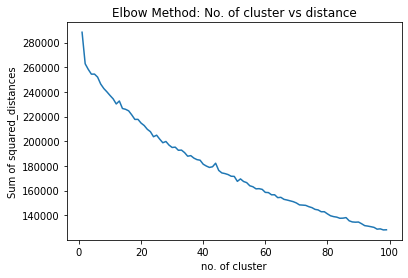

In [71]:
plt.plot(K, ssq_dis)
plt.xlabel('no. of cluster')
plt.ylabel('Sum of squared_distances')
plt.title('Elbow Method: No. of cluster vs distance')
plt.show()

A per the above method the best cluster is 40 training the cluster on the same.

In [73]:
k = 40
kmeans_model = KMeans(n_clusters=k)
kmeans_model = kmeans_model.fit(words_tf_idf)